In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">2º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº 49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# 1 - Introdução




# 2 - Desenvolvimento


## 2.1 - Transformação de dados com TF-IDF

limpeza dos textos (HTML, regex, min_df, etc.),

seleção de parâmetros do TfidfVectorizer (ex.: min_df, max_df, ngram_range, token_pattern, stop_words, norm, etc.),

evitar vocabulários demasiado grandes (afetam desempenho e overfitting).


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from nltk.stem import  LancasterStemmer

# carregar dados
D = pickle.load(open("imdbFull.p", "rb"))
data = D["data"]
data = data[0:5000] # TODO: Remove this when pickling the final data
labels = D["target"]
lancaster = LancasterStemmer()

def clean_text(t):
    t = t.replace("<br />", " ")                  
    t = re.sub(r"[^a-zA-Z]+", " ", t)             
    t = t.lower()
    return t

def apply_stemming(text, stemmer):
    return " ".join(stemmer.stem(word) for word in text.split())


def vectorize_data(data, stemmer, use_pickled=False):
    fname = "vectorized.pkl"
    X_clean = []
    
    if(use_pickled == True):
        f = open(fname, 'rb')
        X_clean = pickle.load(f)
    else:    
        for t in data:
            cleaned = clean_text(t)
            cleaned = apply_stemming(cleaned, stemmer)
            X_clean.append(cleaned)

    vectorizer = TfidfVectorizer(
        min_df=5,                       
        stop_words="english",           
        token_pattern=r"[a-zA-Z]{3,}",  
        ngram_range=(1,2)
    )

    if(use_pickled == False):
        f = open(fname, 'wb')
        pickle.dump(X_clean, f)
    
    return X_clean, vectorizer


In [2]:
# TODO: The test train split needs to be done BEFORE the transform. the transform is for each one
X_clean, vectorizer = vectorize_data(data, lancaster, use_pickled=False)
X_transformed = vectorizer.fit_transform(X_clean) # This SHOULD be pickled

## 2.2 - Treino de Classificadores 
- train/test split com estratificação,
- k-fold cross validation, StratifiedKFold,

- análise de métricas: matriz de confusão, recall, precision.



In [ ]:
# regressor linear com test train split e idf
# exemplo feito durante a aula só para referencia para a malta. Usar o vectorizer de cima
"""
X_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)

# fit no train
idf = TfidfVectorizer(min_df=5).fit(X_train)

# transform train e test
X_train_idf = idf.transform(X_train)
X_test_idf = idf.transform(X_test)

# regressor linear
lr = LogisticRegression(max_iter=1000)

# fit
lr.fit(X_train_idf, y_train)

# predict
lr.predict(X_test_idf)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)\n\n# fit no train\nidf = TfidfVectorizer(min_df=5).fit(X_train)\n\n# transform train e test\nX_train_idf = idf.transform(X_train)\nX_test_idf = idf.transform(X_test)\n\n# regressor linear\nlr = LogisticRegression(max_iter=1000)\n\n# fit\nlr.fit(X_train_idf, y_train)\n\n# predict\nlr.predict(X_test_idf)\n'

### 2.2.1 - Classificação multi-classe

Treinar um modelo que recebe o texto da crítica e prevê a pontuação exata (1–4 ou 7–10 → total de 8 classes).
- Escolhes um ou mais modelos adequados (com base nos slides):
- Exemplos de classificadores
- Logistic Regression,
- SVM,
- Linear Regression,
- Lasso Regression

Depois:
-  comparar classificadores e regressões,
- converter previsões da regressão em classes,
- analisar qual abordagem funciona melhor.

### 2.2.2 - Análise com Regressão Linear

Treinar um modelo para prever a pontuação contínua da crítica. Depois, converter as previsões contínuas do regressor para rótulos de classificação:

valores preditos → mapeados para 1–4 e 7–10.


### 2.2.3 - Análise dos resultados

- desempenho da classificação direta,
- desempenho da classificação derivada da regressão.
Para regressão, medir:
- MAE
- MSE

## 2.3 - Clustering

1. Aplicar K-Means como método base de clustering.
2. Aplicar um segundo método (AgglomerativeClustering) para comparação.
3. Avaliar e comparar os métodos considerando:
    - separação dos clusters (silhouette)
    - distância entre centróides
    - palavras representativas
    - consistência visual (PCA)
    - distribuição dos clusters
4. Investigar o impacto da variação de k no desempenho e interpretação dos clusters.
5. Escolher o método e valor de k mais adequado com base nas métricas.


In [12]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def top_words_per_cluster(centers, feature_names, n=15):
    for i, c in enumerate(centers):
        print(f"\nCluster {i}:")
        idx = np.argsort(c)[::-1][:n]
        print(", ".join(feature_names[j] for j in idx))


def show_examples_per_cluster(data, labels, n=3):
    for c in np.unique(labels):
        print(f"\n===== Cluster {c} =====")
        idx = np.where(labels == c)[0][:n]
        for i in idx:
            print(data[i][:300], "\n---")

# 
def plot_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X)
    #centers_3d = pca.transform(centers)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
        c=labels, s=3
    )

    #ax.scatter(
    #    centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
    #    c="red", s=300, marker="X", edgecolors="black"
    #)

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()

k = 5

### 2.3.1 - Clustering com KMeans

KMeans (k=5)
Inertia: 4779.846946526064
Silhouette Score: 0.001708660721413046


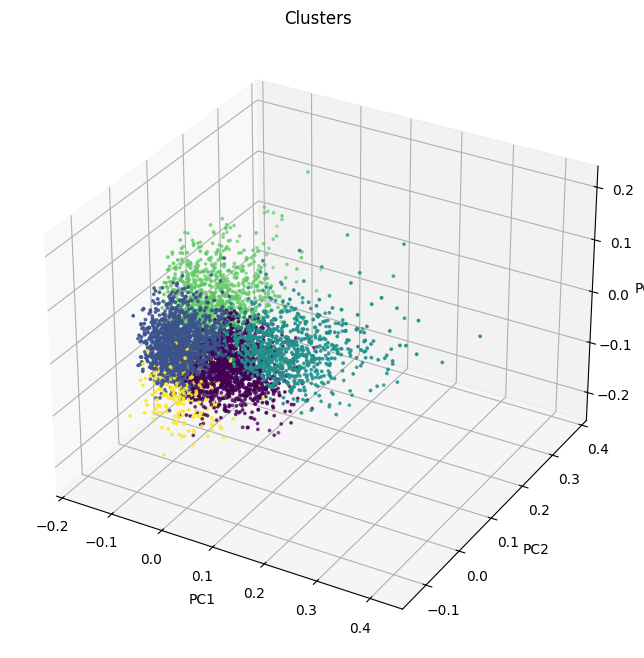

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# número de clusters a testar (ex.: 5)
k = 5 # TODO: Testar vários K

def kmeans_cluster(k, X):
    print(f"KMeans (k={k})")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    kmeans.fit(X)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    inertia = kmeans.inertia_
    sil = None
    
    if k > 1:
        sil = silhouette_score(X, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil

labels_km,centers_km,inertia_km,sil_km = kmeans_cluster(k,X_transformed)


plot_clusters(X_transformed, labels_km)

### 2.3.2 - Clustering com AgglomerativeClustering

AgglomerativeClustering (k=5)
Silhouette Score: -0.001650602953685775


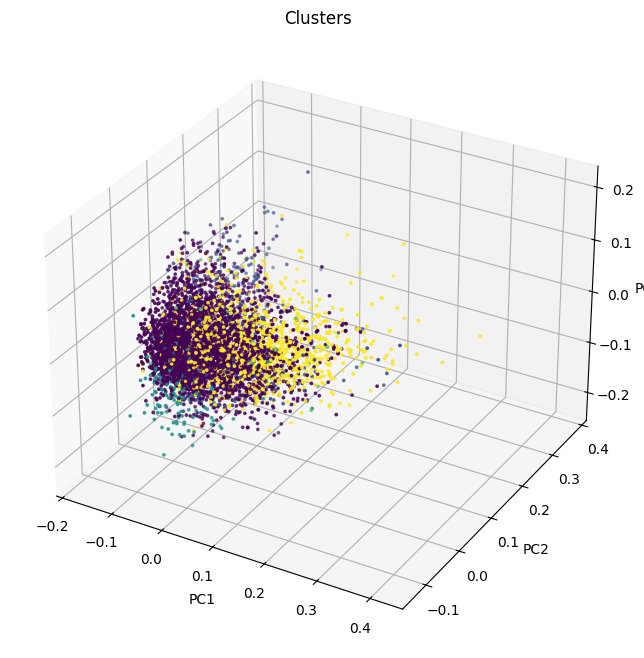

In [14]:
from sklearn.cluster import AgglomerativeClustering


def agg_cluster(k, X):
    print(f"AgglomerativeClustering (k={k})")

    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
    )

    labels = agg.fit_predict(X.toarray())  # hierárquico precisa array
    sil = None
    if(k>1):
        sil = silhouette_score(X, labels)
        print("Silhouette Score:", sil)


    # Calcular centro de cada cluster
    centers = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        centers.append(X[idx].mean(axis=0))

    centers = np.array(centers).squeeze()

    return labels, centers, sil
    
# TODO: Cuidado que aumentar isto é dose
labels_agg,centers_agg,sil_agg = agg_cluster(k,X_transformed)
plot_clusters(X_transformed, labels_agg)


### 2.3.3 - Comparação de clusters e impacto do parametro K

In [16]:
import collections
print(collections.Counter(labels))

"""
# Palavvras dos clusters (cortado aos 400)
for i in range(k):
    print(f"\nCluster {i} exemplo:\n")
    idx = np.where(labels == i)[0][:3]
    for j in idx:
        print(data[j][:400], "\n---")
"""

def compare_methods(sil_kmeans, sil_hier):
    print("\n### Comparação entre métodos ###\n")
    print("Silhouette K-Means:", sil_kmeans)
    print("Silhouette Hierárquico:", sil_hier)

    if sil_kmeans > sil_hier:
        print("\n K-Means apresenta melhor separação de clusters.")
    else:
        print("\nClustering Hierárquico apresenta melhor separação de clusters.")


compare_methods(sil_km, sil_agg)

Counter({np.int32(1): 1455, np.int32(0): 1385, np.int32(3): 1134, np.int32(2): 810, np.int32(4): 216})

### Comparação entre métodos ###

Silhouette K-Means: 0.001708660721413046
Silhouette Hierárquico: -0.001650602953685775

 K-Means apresenta melhor separação de clusters.


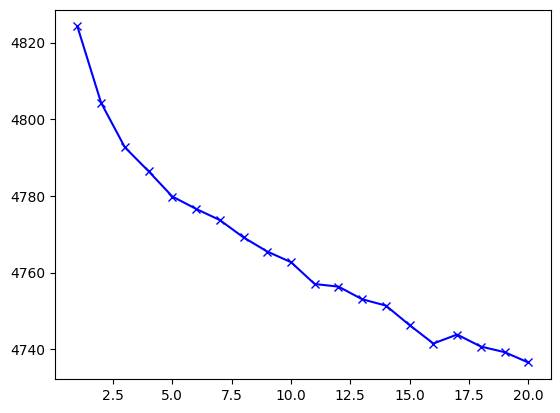

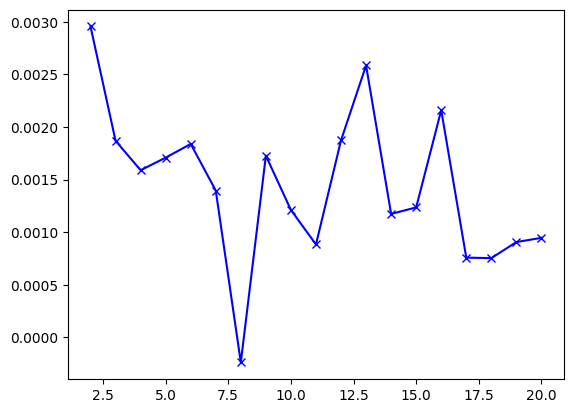

In [ ]:
def evaluate_k_values(X, k_list):
    sil_scores = []
    inertia_scores = []
    print(k_list)
    
    for k in k_list:
        labels, centers, inertia, sil = kmeans_cluster(k,X)
        sil_scores.append(sil)
        inertia_scores.append(inertia)

    return sil_scores, inertia_scores

k_list = range(1,20+1)


sil_scores, inertia_scores = evaluate_k_values(X_transformed,k_list)

plt.plot(k_list, inertia_scores, 'bx-')
plt.show()

plt.plot(k_list, sil_scores, 'bx-')
plt.show()

# 3 - Conclusões

# 4 - Bibliografia

- https://www.reddit.com/r/statistics/comments/180nm8y/question_pca_for_visualizing_clusters/
- https://pca4ds.github.io/pca-and-clustering.html
- https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook